# Calculate mean total evaporation per subcatchment

This Notebook calculates the mean ERA5-Land total evaporation per subcatchment. For each time step, the mean total evaporation is calculated. The created data is used for the S_{u,max} analysis.

## Import required packages

In [1]:
import xarray as xr
import geopandas as gpd
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytz

C:\Users\924259\AppData\Local\Temp\ipykernel_3432\30543826.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Load the shapefile of the subcatchments

In [2]:
shapeloc = r"C:\Users\924259\OneDrive - Royal HaskoningDHV\Documents\Master thesis Daan Idsinga\Data\Precipitation - NRR\Subcatchments"

In [3]:
gdf = gpd.read_file(f'{shapeloc}/GEU_Qstrgbd.shp')

## Set the CRS to EPSG: 4326

In [4]:
gdf.to_crs(4326, inplace=True)

## Open the ERA5-Land total evaporation dataset

In [5]:
nc_file = r"C:\Users\924259\OneDrive - Royal HaskoningDHV\Documents\Master thesis Daan Idsinga\Data\Total Evaporation - ERA5\daily_evaporation.nc"
daily_evap = xr.open_dataset(nc_file)

## Calculate the mean total evaporation per subcatchment

In [8]:
mean_evap_values_per_area = []

# Define the desired shape based on the NetCDF data's dimensions
desired_shape = daily_evap['evaporation'].isel(time=0).shape[-2:]

# Step 3: Calculate the mean potential evaporation per area and per timestep
for idx, row in gdf.iterrows():
    polygon = row['geometry']
    
    # Initialize an empty mask with the desired shape
    mask = np.zeros(desired_shape, dtype=bool)
    
    # Use rasterio.mask.geometry_mask to create a mask for the polygon
    mask = rasterio.mask.geometry_mask([polygon], out_shape=mask.shape, transform=daily_evap.rio.transform(), all_touched = True)
    
    # Reverse mask, subcatchment of interest is set True
    mask = ~mask
    
    # Apply the mask to each timestep and calculate the mean precipitation
    mean_evap_values_per_timestep = []
    for time_idx in range(daily_evap.dims['time']):
        masked_data = daily_evap['evaporation'].isel(time=time_idx).where(mask)
        mean_evap_value = np.nanmean(masked_data)
        mean_evap_values_per_timestep.append(mean_evap_value)
    
    # Store the mean potential evaporation values per timestep for the current area
    mean_evap_values_per_area.append(mean_evap_values_per_timestep)

# Step 4: Add the mean potential evaporation values per timestep to the GeoDataFrame as a new column
gdf['mean_evap_per_timestep'] = mean_evap_values_per_area

# Now, 'gdf' contains a new column 'mean_pot_evap_per_timestep' with the mean values per timestep for each area.
print(gdf)

        Qmeter       A_ha    Shape_Leng    Shape_Area  \
0  Sippenaeken  12330.665  48981.048619  1.233066e+08   
1    Hommerich   3085.801  26032.302283  3.085801e+07   
2     Meerssen   8171.443  67673.767766  8.171443e+07   
3    Eyserbeek   2711.808  31903.689180  2.711808e+07   
4   Selzerbeek   2874.285  28931.939955  2.874285e+07   
5         Gulp   4605.371  43303.162816  4.605371e+07   

                                            geometry  \
0  POLYGON ((5.97782 50.75779, 5.97802 50.75767, ...   
1  POLYGON ((5.91790 50.80742, 5.91974 50.80686, ...   
2  POLYGON ((5.79263 50.91687, 5.79339 50.91633, ...   
3  POLYGON ((5.99215 50.85195, 5.99231 50.85180, ...   
4  POLYGON ((5.96102 50.81920, 5.96130 50.81915, ...   
5  POLYGON ((5.87040 50.82392, 5.87061 50.82365, ...   

                              mean_evap_per_timestep  
0  [0.3545443, 0.15506063, 0.11115583, 0.10641203...  
1  [0.36216033, 0.15585132, 0.13038944, 0.1228379...  
2  [0.3688266, 0.15044355, 0.16430166, 0.1

## Check data

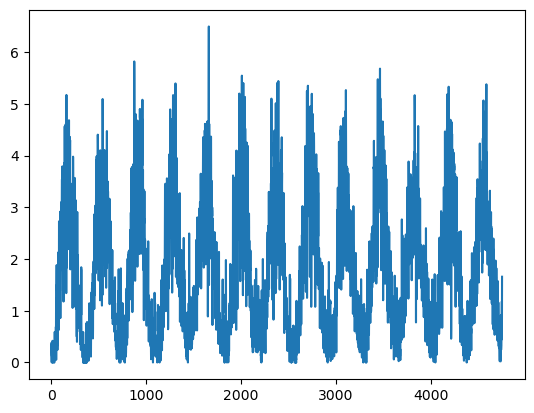

In [12]:
plt.plot(gdf['mean_evap_per_timestep'][5])

## Create Dataframe with the mean total evaporation per subcatchment

In [23]:
daily_evap_mean = pd.DataFrame()

daily_evap_mean['time'] = daily_evap.time.values
daily_evap_mean.set_index('time',inplace = True)
daily_evap_mean['Meerssen'] = gdf['mean_evap_per_timestep'][2]
daily_evap_mean['Gulp'] = gdf['mean_evap_per_timestep'][5]
daily_evap_mean['Eyserbeek'] = gdf['mean_evap_per_timestep'][3]
daily_evap_mean['Selzerbeek'] = gdf['mean_evap_per_timestep'][4]
daily_evap_mean['Hommerich'] = gdf['mean_evap_per_timestep'][1]
daily_evap_mean['Sippenaeken'] = gdf['mean_evap_per_timestep'][0]

In [24]:
daily_evap_mean

,Meerssen,Gulp,Eyserbeek,Selzerbeek,Hommerich,Sippenaeken
time,,,,,,
2010-01-01,0.368827,0.367800,0.373132,0.382201,0.362160,0.354544
2010-01-02,0.150444,0.141668,0.162402,0.167905,0.155851,0.155061
2010-01-03,0.164302,0.137699,0.150591,0.146509,0.130389,0.111156
2010-01-04,0.152518,0.127727,0.138780,0.141281,0.122838,0.106412
2010-01-05,0.109837,0.111801,0.108736,0.114270,0.109284,0.106154
...,...,...,...,...,...,...
2022-12-27,0.403848,0.444452,0.429651,0.452923,0.444225,0.460177
2022-12-28,1.235100,1.168669,1.168012,1.151118,1.150063,1.146249
2022-12-29,1.241596,1.180694,1.224064,1.226823,1.190439,1.210011


## Download the create Dataframe

In [28]:
daily_evap_mean.to_csv('C:/Users/924259\OneDrive - Royal HaskoningDHV\Documents\Master thesis Daan Idsinga\Data\Total Evaporation - ERA5\/daily_evaporation_mean.csv')

## Data plot

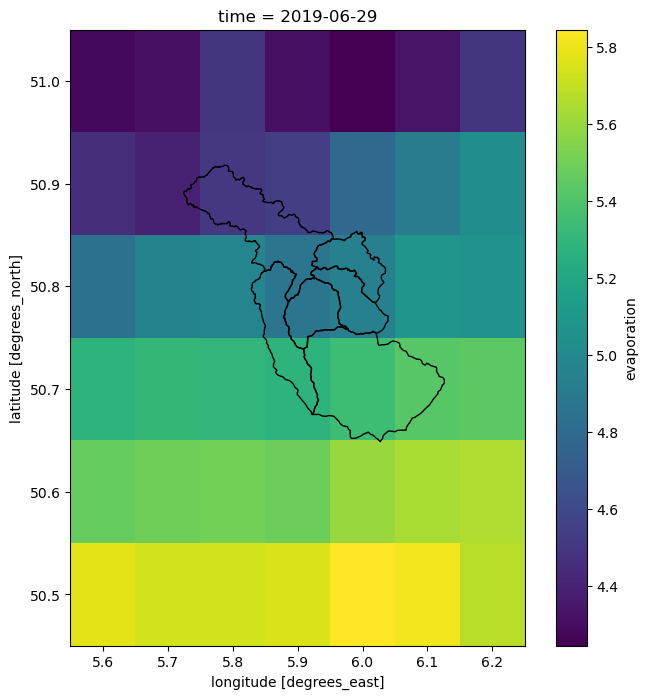

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
daily_evap.evaporation.sel(time='2019-06-29').plot(ax=ax)
gdf.plot(ax=ax, edgecolor='black', color='none');